# GroupedQueryAttention - GQA
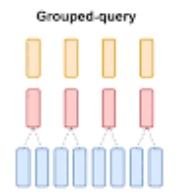

similar to MQA but used a set of shared Key and value heads instead of one , for the Query heads  
query heads are divided into groups , which share a single key and value head   
requires more memory than MQA but gives better performance

In [1]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import math

## without KV_Cache or Causal Masking

In [12]:
class GroupedQueryAttention(nn.Module):
    def __init__(self, d_model, num_heads, n_kv_heads):
        super().__init__()

        self.d_model = d_model 
        self.num_heads = num_heads 
        self.n_kv_heads = n_kv_heads
        self.d_kv = d_model // num_heads  

        self.W_q = nn.Linear(d_model, d_model, bias=False)
        
        # n heads
        self.W_k = nn.Linear(d_model, self.n_kv_heads * self.d_kv, bias=False)
        self.W_v = nn.Linear(d_model, self.n_kv_heads * self.d_kv, bias=False)

        self.W_o = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x): 
        batch, seq, d_model = x.shape

        Q = self.W_q(x) # d_model = heads*d_kv
        Q = Q.view(batch, seq, self.num_heads, self.d_kv).transpose(1,2)
        print(f"Query shape before groups : {Q.shape}")

        K = self.W_k(x)
        V = self.W_v(x)

        K = K.view(batch, seq, self.n_kv_heads, self.d_kv).transpose(1,2)
        V = V.view(batch, seq, self.n_kv_heads, self.d_kv).transpose(1,2)

        n_g = self.num_heads // self.n_kv_heads # query heads per n kv heads
        print(f"query head per kv heads: {n_g}")

        # creating groups in query matrix
        Q = Q.view(batch, self.n_kv_heads, n_g, seq, self.d_kv)
        print(f"Q shape after grouping : {Q.shape}")

        scores = torch.einsum("b h g n d, b h s d -> b h g n s", Q, K) # QK^T
        print(f"shape of scores : {scores.shape}")

        attn_scores = F.softmax(scores / math.sqrt(self.d_kv), dim=-1)
        print(f"should be 1 if correct: {attn_scores.sum(dim=-1)}")

        attn_weights = torch.einsum("b h g n s, b h s d -> b h g n d", attn_scores, V) # s summed over to produce n
        print(f"shape of attn weights : {attn_weights.shape}")

        attn_weights = attn_weights.view(batch, self.num_heads, seq, self.d_kv) # merging heads

        attn_outputs = attn_weights.transpose(1,2).contiguous()
        attn_outputs = attn_outputs.view(batch, seq, d_model)

        out = self.W_o(attn_outputs)
        print(f"out shape : {out.shape}")

        return out



In [13]:
batch = 2 
seq =  10
d_model = 64 
num_heads = 8
num_kv_heads = 2 

x = torch.randn(batch, seq, d_model)
print(f"x.shape : {x.shape}")

gqa = GroupedQueryAttention(d_model, num_heads, num_kv_heads)
out = gqa(x)

x.shape : torch.Size([2, 10, 64])
Query shape before groups : torch.Size([2, 8, 10, 8])
query head per kv heads: 4
Q shape after grouping : torch.Size([2, 2, 4, 10, 8])
shape of scores : torch.Size([2, 2, 4, 10, 10])
should be 1 if correct: tensor([[[[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1

## with KV Cache only

In [21]:
class GroupedQueryAttention_V2(nn.Module):
    def __init__(self, d_model, num_heads, n_kv_heads):
        super().__init__()

        self.d_model = d_model 
        self.num_heads = num_heads 
        self.n_kv_heads = n_kv_heads
        self.d_kv = d_model // num_heads  

        self.W_q = nn.Linear(d_model, d_model, bias=False)
        
        # n heads
        self.W_k = nn.Linear(d_model, self.n_kv_heads * self.d_kv, bias=False)
        self.W_v = nn.Linear(d_model, self.n_kv_heads * self.d_kv, bias=False)

        self.W_o = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x, kv_cache=None, use_kv_cache=False): 
        batch, seq, d_model = x.shape

        Q = self.W_q(x) # d_model = heads*d_kv
        Q = Q.view(batch, seq, self.num_heads, self.d_kv).transpose(1,2)
        # print(f"Query shape before groups : {Q.shape}")

        K = self.W_k(x)
        V = self.W_v(x)

        K = K.view(batch, seq, self.n_kv_heads, self.d_kv).transpose(1,2)
        V = V.view(batch, seq, self.n_kv_heads, self.d_kv).transpose(1,2)

        n_g = self.num_heads // self.n_kv_heads # query heads per n kv heads
        print(f"query head per kv heads: {n_g}")

        # creating groups in query matrix
        Q = Q.view(batch, self.n_kv_heads, n_g, seq, self.d_kv)
        # print(f"Q shape after grouping : {Q.shape}")

        if kv_cache is not None:
            K = torch.concat([kv_cache["k"], K], dim=2)
            V = torch.concat([kv_cache["v"], V], dim=2)
        
        if use_kv_cache:
            new_kv_cache = {
                "k" : K.detach(),
                "v" : V.detach(),
            }
        else:
            new_kv_cache = None 

        print(f"Q shape : {Q.shape}\nK shape: {K.shape}\nV shape {V.shape}")

        scores = torch.einsum("b h g n d, b h s d -> b h g n s", Q, K) # QK^T
        # print(f"shape of scores : {scores.shape}")

        attn_scores = F.softmax(scores / math.sqrt(self.d_kv), dim=-1)
        # print(f"should be 1 if correct: {attn_scores.sum(dim=-1)}")

        attn_weights = torch.einsum("b h g n s, b h s d -> b h g n d", attn_scores, V) # s summed over to produce n
        # print(f"shape of attn weights : {attn_weights.shape}")

        attn_weights = attn_weights.view(batch, self.num_heads, seq, self.d_kv) # merging heads

        attn_outputs = attn_weights.transpose(1,2).contiguous()
        attn_outputs = attn_outputs.view(batch, seq, d_model)

        out = self.W_o(attn_outputs)
        print(f"out shape : {out.shape}")

        return out, new_kv_cache



In [22]:
batch = 2 
seq =  10
d_model = 64 
num_heads = 8
num_kv_heads = 2 

x = torch.randn(batch, seq, d_model)
print(f"x.shape : {x.shape}")

gqa_v2 = GroupedQueryAttention_V2(d_model, num_heads, num_kv_heads)
# out = gqa_v2(x)

kv_cache = None
for i in range(seq):
    print(f"\n--------------------")
    x_token = x[:, i:i+1, :] # batch , 1 , d_model
    output, kv_cache = gqa_v2(x_token, kv_cache=kv_cache, use_kv_cache=True)

x.shape : torch.Size([2, 10, 64])

--------------------
query head per kv heads: 4
Q shape : torch.Size([2, 2, 4, 1, 8])
K shape: torch.Size([2, 2, 1, 8])
V shape torch.Size([2, 2, 1, 8])
out shape : torch.Size([2, 1, 64])

--------------------
query head per kv heads: 4
Q shape : torch.Size([2, 2, 4, 1, 8])
K shape: torch.Size([2, 2, 2, 8])
V shape torch.Size([2, 2, 2, 8])
out shape : torch.Size([2, 1, 64])

--------------------
query head per kv heads: 4
Q shape : torch.Size([2, 2, 4, 1, 8])
K shape: torch.Size([2, 2, 3, 8])
V shape torch.Size([2, 2, 3, 8])
out shape : torch.Size([2, 1, 64])

--------------------
query head per kv heads: 4
Q shape : torch.Size([2, 2, 4, 1, 8])
K shape: torch.Size([2, 2, 4, 8])
V shape torch.Size([2, 2, 4, 8])
out shape : torch.Size([2, 1, 64])

--------------------
query head per kv heads: 4
Q shape : torch.Size([2, 2, 4, 1, 8])
K shape: torch.Size([2, 2, 5, 8])
V shape torch.Size([2, 2, 5, 8])
out shape : torch.Size([2, 1, 64])

--------------------

## with both KV Cache and causal masking

In [28]:
class GroupedQueryAttention_V3(nn.Module):
    def __init__(self, d_model, num_heads, n_kv_heads):
        super().__init__()

        self.d_model = d_model 
        self.num_heads = num_heads 
        self.n_kv_heads = n_kv_heads
        self.d_kv = d_model // num_heads  

        self.W_q = nn.Linear(d_model, d_model, bias=False)
        
        # n heads
        self.W_k = nn.Linear(d_model, self.n_kv_heads * self.d_kv, bias=False)
        self.W_v = nn.Linear(d_model, self.n_kv_heads * self.d_kv, bias=False)

        self.W_o = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x, kv_cache=None, use_kv_cache=False): 
        batch, seq, d_model = x.shape

        Q = self.W_q(x) # d_model = heads*d_kv
        Q = Q.view(batch, seq, self.num_heads, self.d_kv).transpose(1,2)
        # print(f"Query shape before groups : {Q.shape}")

        K = self.W_k(x)
        V = self.W_v(x)

        K = K.view(batch, seq, self.n_kv_heads, self.d_kv).transpose(1,2)
        V = V.view(batch, seq, self.n_kv_heads, self.d_kv).transpose(1,2)

        n_g = self.num_heads // self.n_kv_heads # query heads per n kv heads
        print(f"query head per kv heads: {n_g}")

        # creating groups in query matrix
        Q = Q.view(batch, self.n_kv_heads, n_g, seq, self.d_kv)
        # print(f"Q shape after grouping : {Q.shape}")

        past_len = 0
        if kv_cache is not None:
            K = torch.concat([kv_cache["k"], K], dim=2)
            V = torch.concat([kv_cache["v"], V], dim=2)
            past_len = kv_cache["k"].shape[2]
        
        if use_kv_cache:
            new_kv_cache = {
                "k" : K.detach(),
                "v" : V.detach(),
            }
        else:
            new_kv_cache = None 

        print(f"Q shape : {Q.shape}\nK shape: {K.shape}\nV shape {V.shape}")

        scores = torch.einsum("b h g n d, b h s d -> b h g n s", Q, K) # QK^T
        if seq > 1:
            total_len = past_len+seq 
            scores = scores.masked_fill(torch.triu(torch.ones(seq, total_len, dtype=torch.bool, device=scores.device), diagonal=past_len+1), float("-inf"))
        # print(f"shape of scores : {scores.shape}")

        attn_scores = F.softmax(scores / math.sqrt(self.d_kv), dim=-1)
        print(f"should be 1 if correct: {attn_scores.sum(dim=-1)}")

        attn_weights = torch.einsum("b h g n s, b h s d -> b h g n d", attn_scores, V) # s summed over to produce n
        print(f"shape of attn weights : {attn_weights.shape}")

        attn_weights = attn_weights.view(batch, self.num_heads, seq, self.d_kv) # merging heads

        attn_outputs = attn_weights.transpose(1,2).contiguous()
        attn_outputs = attn_outputs.view(batch, seq, d_model)

        out = self.W_o(attn_outputs)
        print(f"out shape : {out.shape}")

        return out, new_kv_cache



In [29]:
batch = 2 
seq =  10
d_model = 64 
num_heads = 8
num_kv_heads = 2 

x = torch.randn(batch, seq, d_model)
print(f"x.shape : {x.shape}")

gqa_v3 = GroupedQueryAttention_V3(d_model, num_heads, num_kv_heads)
out = gqa_v3(x)

kv_cache = None
for i in range(seq):
    print(f"\n--------------------")
    x_token = x[:, i:i+1, :] # batch , 1 , d_model
    output, kv_cache = gqa_v3(x_token, kv_cache=kv_cache, use_kv_cache=True)

x.shape : torch.Size([2, 10, 64])
query head per kv heads: 4
Q shape : torch.Size([2, 2, 4, 10, 8])
K shape: torch.Size([2, 2, 10, 8])
V shape torch.Size([2, 2, 10, 8])
should be 1 if correct: tensor([[[[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         

Thus, have implemented Grouped Query Attention with Kv Cache and masking